<div class="alert alert-danger" role="alert">
<h2> Important information </h2><br>

This is a version of the notebook with the solutions to the challenges.
> Make sure to finish the "student" version first.
    
At the end of the second and third chapter, you will find workgroup assignments in GREEN font color.
    
> The three prespecified assignments will sum up to 100 points. You need a minumum of 50 points for a passing grade.
    
> For individual assignment, make sure to discuss with the workgroup teacher!
    
</div>


# Reinforcement Learning in bandit tasks and gridworlds

Steven Miletic<br>
<sub>Leiden University<sub><br><br>  
    
This is the code for the practical session in the course "2425-S1 Cognitive Modelling: How to build a brain" [(link to Brightspace)](https://brightspace.universiteitleiden.nl/d2l/home/309838)<br>   
Date: September 30th 2024<br>

Code based on [Franz Wurm's version of last year](https://github.com/fwurm/teaching_CognitiveModelling)

**Useful references**
- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

# 5.

<div class="alert alert-success" role="alert">
<h2> Assignment 1: The impact of context (40 points) </h2><br>
Besides the bandits encountered above, we can construct a wide variety of different versions.
    
For example, the type of reward distribution can be varied. We have already encountered _binomial rewards_ in the <code>draw_from_k_bandits</code>. For this bandit, reward distributions indicated the reward probablity associated with each action. We have also already encountered _Gaussian rewards_ in the <code>draw_from_k_gaussian_bandits</code>. Contrary to the binomial rewards, determinstic rewards do not include binomial noise, but Gaussian noise.  

Moreover, we can make a distinction between _stationary (stable)_ and _walking (volatile)_ reward distributions. So far, we have only encountered fixed rewards distributions. Rewards were always drawn from a stable environment and did not change over time. We simulated a walking bandit by generating multiple different walks and glueing them together (flattening).

For truely walking rewards distributions, noise is added to the defining parameters of the distribution. For example, on every new trial of our <code>draw_from_k_bandits</code>, the new reward probablity could be set to the old rewards probability plus some normal noise with mean 0 and standard deviation 0.05. Please note, that this makes it necessary to define bounds, as rewards probabilities (e.g., binomial) need to be set between 0 and 1. Gaussian rewards should not wander off too much but rather stay between 0 and 100.


> Set up the 4 possible bandits with the following properties (20 points) <br>
> 1. Binomial rewards with fixed reward probabilities (as implemented already in <code>generate_uniform_bandit</code>)
> 2. Binomial rewards with walking reward probabilities
> 3. Gaussian rewards with fixed mean rewards (bound between 0 and 100)
> 4. Gaussian rewards with walking mean rewards (bound between 0 and 100)

> Visualize the bandits. For visualization, use one-armed variants. Plot their true reward probabilites, obtained rewards, etc. (10 points)

> Plot how the performance of our weighted average, softmax RL agents differs between these bandits. For this excersise, use two-armed bandits. For the agent, fix the learning rate (alpha) to 0.1 and the softmax inverse temperature (beta) to 2. (10 points)

</div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
# Binomial rewards with fixed probabilities
def draw_from_fixed_binomial_bandits(n_trials, reward_probs):
    n_bandits = len(reward_probs)
    reward_samples = np.empty((n_bandits, n_trials))
    reward_probs_matrix = np.empty((n_bandits, n_trials))

    for i, prob in enumerate(reward_probs):
        reward_samples[i, :] = np.random.binomial(1, prob, n_trials)
        reward_probs_matrix[i, :] = prob  # Store fixed probabilities
    return reward_samples, reward_probs_matrix

# Binomial rewards with walking probabilities
def simulate_bandit_with_walking_probs(n_trials, init_probs, lr=0.05, noise=0.05):
    n_bandits = len(init_probs)
    reward_samples = np.empty((n_bandits, n_trials))
    reward_probs = np.empty((n_bandits, n_trials))

    for i in range(n_trials):
        if i == 0:
            reward_probs[:, i] = init_probs
        else:
            reward_probs[:, i] = reward_probs[:, i-1] + lr * np.random.normal(0, noise, n_bandits)
            reward_probs[:, i] = np.clip(reward_probs[:, i], 0, 1)
        reward_samples[:, i] = np.random.binomial(1, reward_probs[:, i])
    return reward_probs, reward_samples

# Gaussian rewards with fixed mean rewards
def draw_from_k_fixed_gaussian_bandits(n_trials, mean_rewards):
    n_bandits = len(mean_rewards)
    clipped_means = np.clip(mean_rewards, 0, 100)
    reward_samples = np.empty((n_bandits, n_trials))
    reward_means = np.empty((n_bandits, n_trials))

    for i, mean_reward in enumerate(clipped_means):
        reward_samples[i, :] = np.random.normal(loc=mean_reward, scale=1, size=n_trials)
        reward_means[i, :] = mean_reward  # Store the fixed mean rewards
    return reward_samples, reward_means

# Gaussian rewards with walking mean rewards
def draw_from_k_walking_gaussian_bandits(n_trials, init_means, lr=0.05, noise=0.05):
    n_bandits = len(init_means)
    reward_samples = np.empty((n_bandits, n_trials))
    reward_means = np.empty((n_bandits, n_trials))
    reward_means[:, 0] = np.clip(init_means, 0, 100)

    for i in range(1, n_trials):
        # Update the means with a combination of the previous mean and new noise
        reward_means[:, i] = reward_means[:, i-1] + lr * np.random.normal(0, noise, n_bandits)
        reward_means[:, i] = np.clip(reward_means[:, i], 0, 100)  # Ensure means are within bounds
        reward_samples[:, i] = np.random.normal(loc=reward_means[:, i], scale=1)
    return reward_samples, reward_means

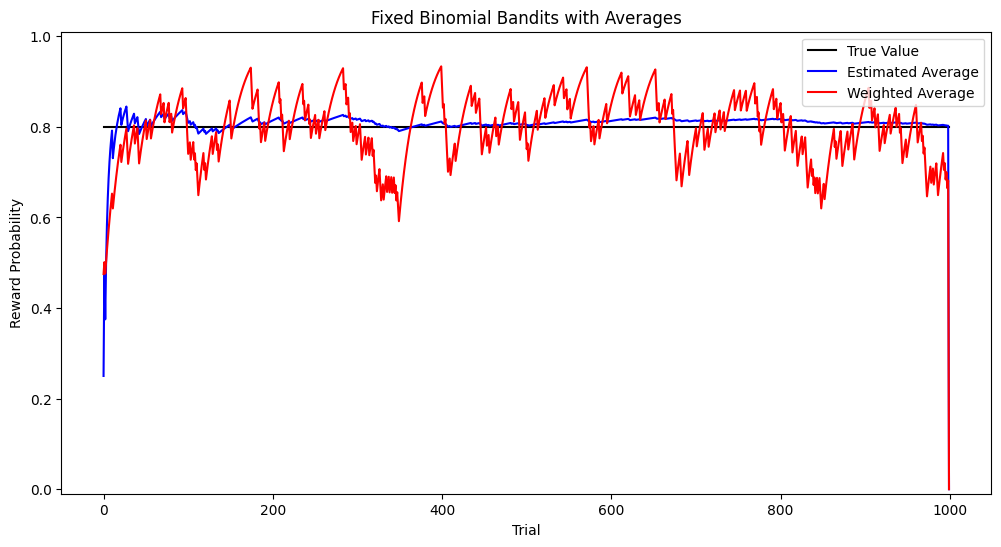

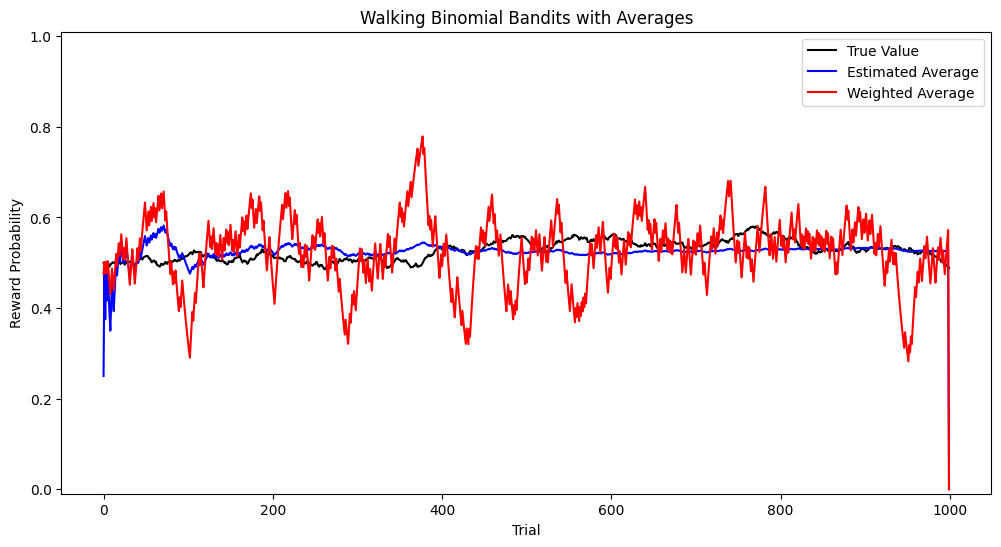

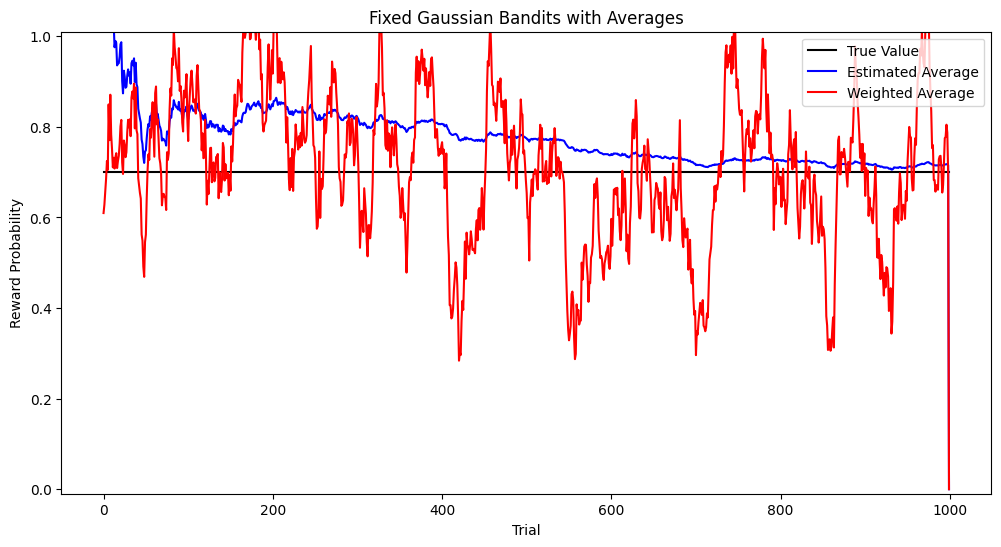

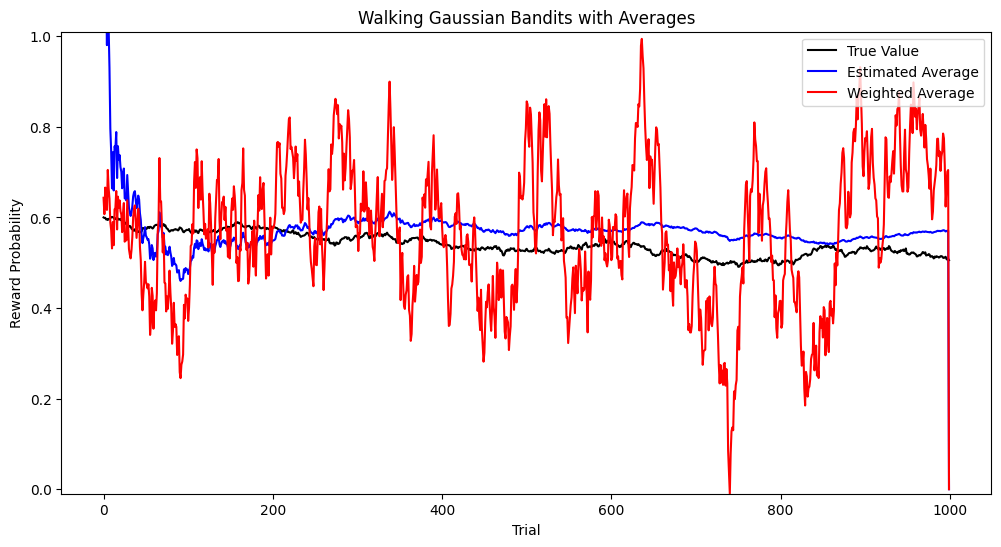

In [ ]:
# Plotting function for estimates
def plot_reward_estimates_with_weighted_avg(reward_probs_or_means, reward_samples, n_trials, title, lr=0.05, reward_type='binomial'):
    mean_avg = np.zeros(n_trials + 1)  # Incremental average
    weighted_avg = np.zeros(n_trials + 1)  # Weighted average

    for iT in range(n_trials):
        if iT == 0:
            mean_avg[iT] = 0.5 if reward_type == 'binomial' else np.mean(reward_samples)
            weighted_avg[iT] = mean_avg[iT]
        else:
            # Incremental average update rule
            mean_avg[iT] = mean_avg[iT - 1] + (1 / (iT + 1)) * (reward_samples[0, iT] - mean_avg[iT - 1])

            # Weighted average update rule
            weighted_avg[iT] = weighted_avg[iT - 1] + lr * (reward_samples[0, iT] - weighted_avg[iT - 1])

    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(np.arange(n_trials), reward_probs_or_means[0, :], '-k', label='True Value' if reward_type == 'binomial' else 'True Mean')
    ax.plot(np.arange(n_trials), mean_avg[1:], '-b', label='Estimated Average')
    ax.plot(np.arange(n_trials), weighted_avg[1:], '-r', label='Weighted Average')

    # Adjust y-axis limits and labels based on reward type
    if reward_type == 'binomial':
        ax.set_ylim([-0.01, 1.01])
        ax.set_ylabel('Reward Probability')
    else:
        ax.set_ylim([np.min(reward_samples) - 0.5, np.max(reward_samples) + 0.5])
        ax.set_ylabel('Reward')

    plt.legend(loc="upper right")
    ax.set_xlabel('Trial')
    ax.set_title(title)
    plt.show()

n_trials = 1000

# Binomial rewards with fixed probabilities
probs_fixed_binomial = [0.8]  # Fixed reward probability
reward_samples_fixed_binomial, reward_probs_fixed_binomial = draw_from_fixed_binomial_bandits(n_trials, probs_fixed_binomial)
plot_reward_estimates_with_weighted_avg(reward_probs_fixed_binomial, reward_samples_fixed_binomial, n_trials, "Fixed Binomial Bandits with Averages", lr=0.05)

# Walking Binomial Bandits
probs_walking_binomial = [0.5]  # Initial reward probability
reward_probs_walking_binomial, reward_samples_walking_binomial = simulate_bandit_with_walking_probs(n_trials, probs_walking_binomial)
plot_reward_estimates_with_weighted_avg(reward_probs_walking_binomial, reward_samples_walking_binomial, n_trials, "Walking Binomial Bandits with Averages", lr=0.05)

# Fixed Gaussian bandits
means_fixed_gaussian = [0.7]  # Fixed mean rewards
reward_samples_fixed_gaussian, reward_means_fixed_gaussian = draw_from_k_fixed_gaussian_bandits(n_trials, means_fixed_gaussian)
plot_reward_estimates_with_weighted_avg(reward_means_fixed_gaussian, reward_samples_fixed_gaussian, n_trials, "Fixed Gaussian Bandits with Averages", lr=0.05)

# Walking Gaussian bandits
means_walking_gaussian = [0.6]  # Initial mean rewards
reward_samples_walking_gaussian, reward_means_walking_gaussian = draw_from_k_walking_gaussian_bandits(n_trials, means_walking_gaussian)
plot_reward_estimates_with_weighted_avg(reward_means_walking_gaussian, reward_samples_walking_gaussian, n_trials, "Walking Gaussian Bandits with Averages", lr=0.05)

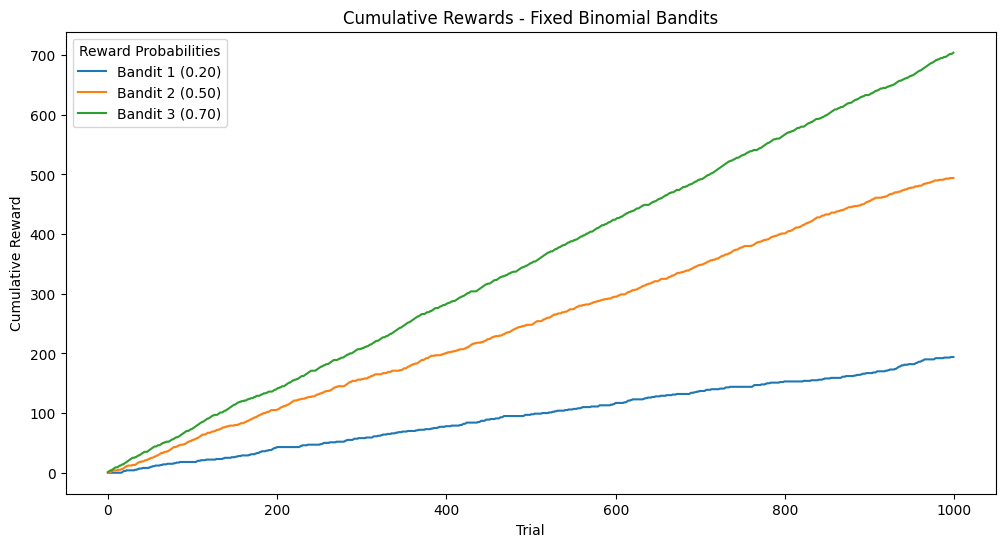

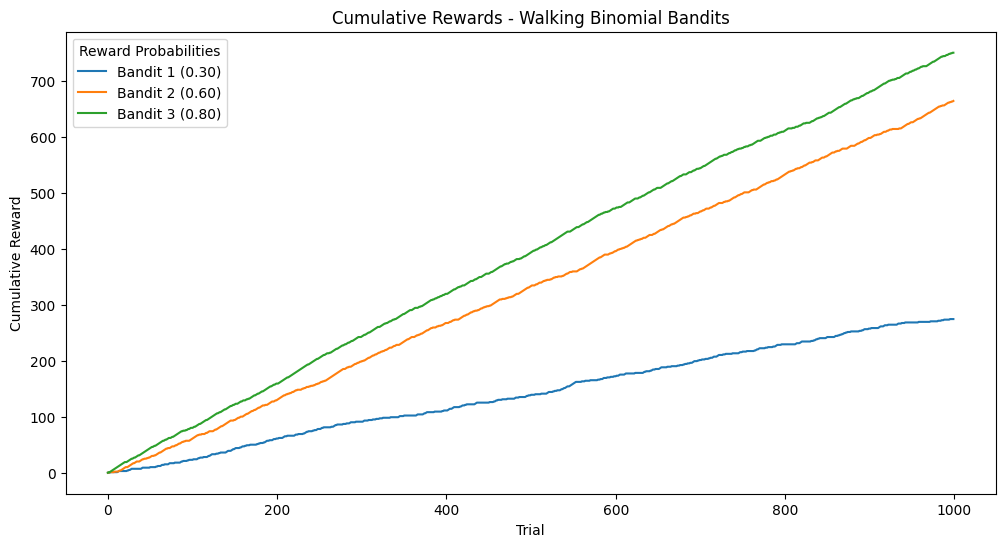

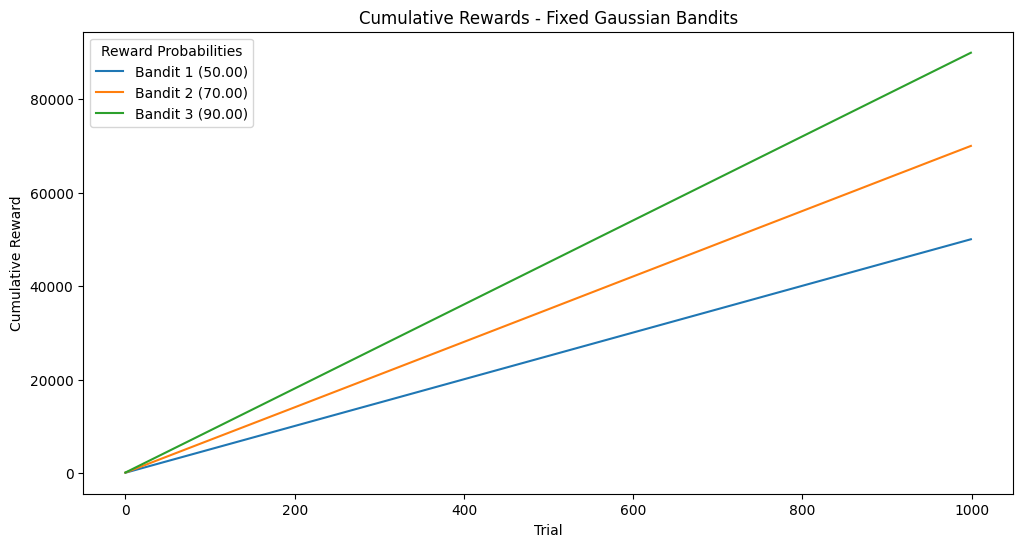

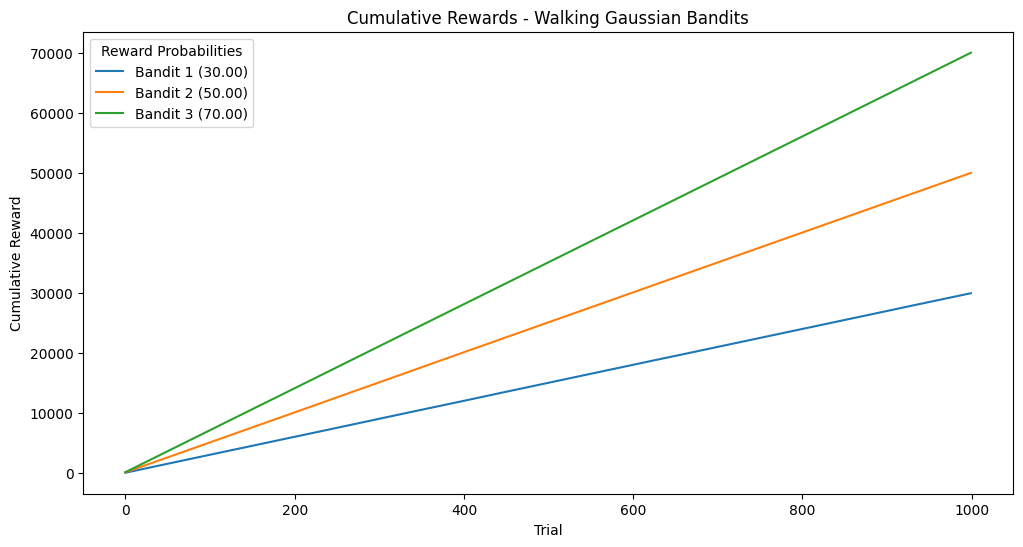

In [ ]:
def plot_cumulative_rewards(reward_samples, n_trials, title, legend_values):
    """
    Plots the cumulative obtained rewards over trials for any bandit setup.

    Parameters:
    reward_samples (ndarray): Simulated reward samples from the bandits over the trials.
    n_trials (int): Number of trials.
    title (str): Title for the plot.
    legend_values (list): List of reward probabilities or means for the legend.
    """
    # Compute cumulative rewards for each bandit
    cumulative_rewards = np.cumsum(reward_samples, axis=1)

    # Plot the cumulative rewards over time
    plt.figure(figsize=(12, 6))
    for i in range(reward_samples.shape[0]):
        plt.plot(np.arange(n_trials), cumulative_rewards[i, :], label=f'Bandit {i+1} ({float(legend_values[i]):.2f})')

    plt.xlabel('Trial')
    plt.ylabel('Cumulative Reward')
    plt.title(title)
    plt.legend(title='Reward Probabilities')  # Optional title for the legend
    plt.show()

# Example usage for different bandit setups
n_trials = 1000
reward_probs = [0.2, 0.5, 0.7]  # For fixed binomial bandits
init_probs = [0.3, 0.6, 0.8]  # For walking binomial bandits
mean_rewards = [50, 70, 90]  # For fixed gaussian bandits
init_means = [30, 50, 70]  # For walking gaussian bandits

# Binomial with fixed probabilities
reward_samples_fixed_binomial, _ = draw_from_fixed_binomial_bandits(n_trials, reward_probs)
plot_cumulative_rewards(reward_samples_fixed_binomial, n_trials, "Cumulative Rewards - Fixed Binomial Bandits", reward_probs)

# Binomial with walking probabilities
reward_probs_walking, reward_samples_walking_binomial = simulate_bandit_with_walking_probs(n_trials, init_probs)
plot_cumulative_rewards(reward_samples_walking_binomial, n_trials, "Cumulative Rewards - Walking Binomial Bandits", init_probs)

# Gaussian with fixed means
reward_samples_fixed_gaussian, _ = draw_from_k_fixed_gaussian_bandits(n_trials, mean_rewards)
plot_cumulative_rewards(reward_samples_fixed_gaussian, n_trials, "Cumulative Rewards - Fixed Gaussian Bandits", mean_rewards)

# Gaussian with walking means
reward_samples_walking_gaussian, _ = draw_from_k_walking_gaussian_bandits(n_trials, init_means)
plot_cumulative_rewards(reward_samples_walking_gaussian, n_trials, "Cumulative Rewards - Walking Gaussian Bandits", init_means)


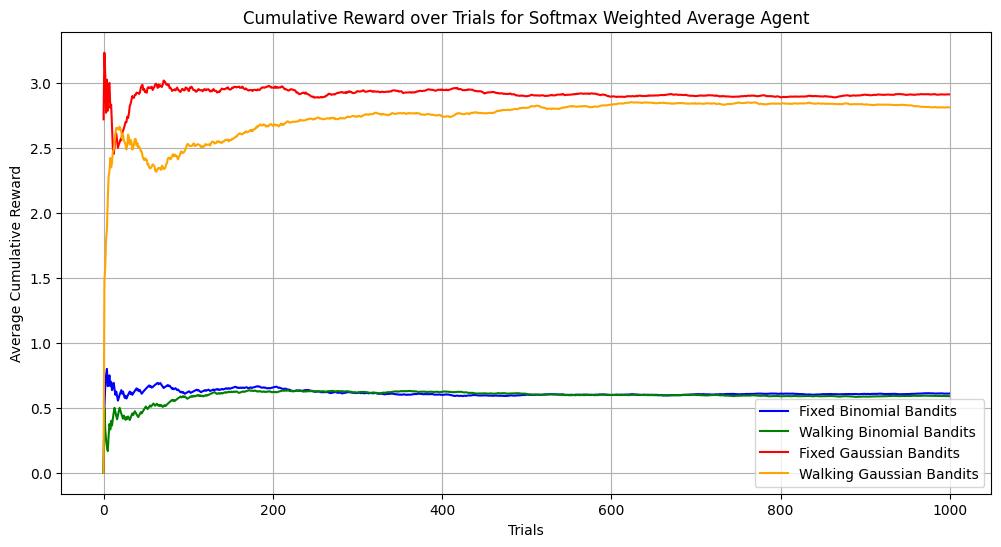

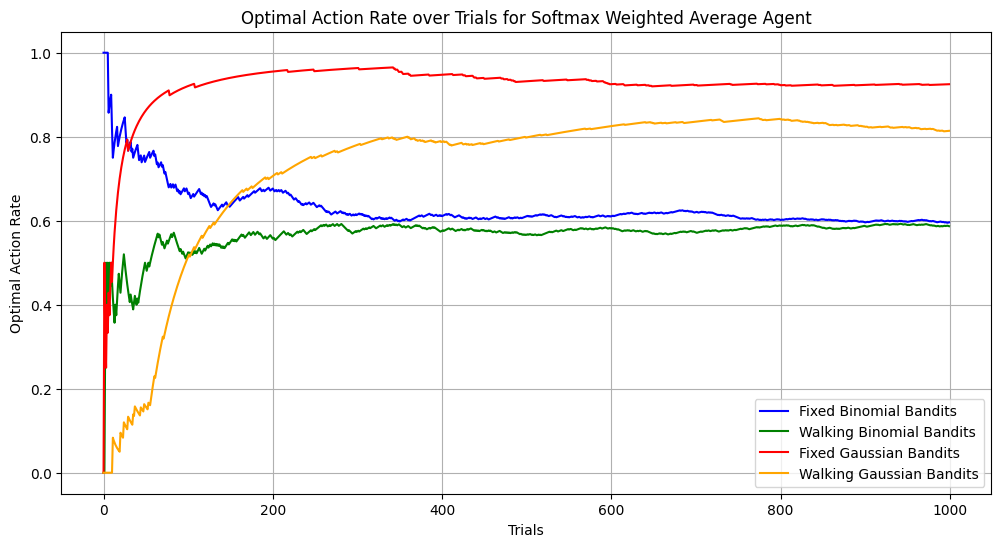

In [ ]:
# Agent combining weighted average and softmax
class SoftmaxWeightedAverageAgent:
    def __init__(self, n_actions, alpha, beta):
        self.alpha = alpha  # Learning rate
        self.beta = beta    # Softmax inverse temperature
        self.action_values = np.zeros(n_actions)
        self.action_counts = np.zeros(n_actions)

    def select_action(self):
        # Softmax selection based on action values
        prob = np.exp(self.beta * self.action_values) / np.sum(np.exp(self.beta * self.action_values))
        action = np.random.choice(len(self.action_values), p=prob)
        return action

    def update_estimates(self, action, reward):
        self.action_counts[action] += 1
        # Update the action value using the weighted average method
        self.action_values[action] += self.alpha * (reward - self.action_values[action])

# Simulation function
def run_simulation(n_trials, reward_probs, agent):
    n_bandits = len(reward_probs)
    total_rewards = np.zeros(n_trials)
    optimal_action_counts = np.zeros(n_trials)

    optimal_action = np.argmax(reward_probs.mean(axis=1))  # Assuming optimal action is the one with highest mean reward

    for i in range(n_trials):
        action = agent.select_action()
        reward = reward_probs[action, i]  # Get reward for the selected action
        agent.update_estimates(action, reward)
        total_rewards[i] = reward

        # Track if the optimal action was chosen
        if action == optimal_action:
            optimal_action_counts[i] = 1

    return total_rewards, optimal_action_counts

# Parameters
n_trials = 1000
n_bandits = 2
alpha = 0.1  # Learning rate
beta = 2.0   # Softmax inverse temperature

# 1. Binomial rewards with fixed probabilities
fixed_reward_probs = [0.5, 0.7]
reward_samples_fixed, _ = draw_from_fixed_binomial_bandits(n_trials, fixed_reward_probs)
agent_fixed = SoftmaxWeightedAverageAgent(n_bandits, alpha, beta)
performance_fixed, optimal_action_fixed = run_simulation(n_trials, reward_samples_fixed, agent_fixed)

# 2. Binomial rewards with walking probabilities
init_probs_binomial = [0.5, 0.7]  # Initial probabilities for walking
_, reward_samples_walking = simulate_bandit_with_walking_probs(n_trials, init_probs_binomial)
agent_walking = SoftmaxWeightedAverageAgent(n_bandits, alpha, beta)
performance_walking, optimal_action_walking = run_simulation(n_trials, reward_samples_walking, agent_walking)

# 3. Gaussian rewards with fixed mean rewards
mean_rewards_gaussian = [2, 3]  # Fixed mean rewards
reward_samples_gaussian, _ = draw_from_k_fixed_gaussian_bandits(n_trials, mean_rewards_gaussian)
agent_gaussian_fixed = SoftmaxWeightedAverageAgent(n_bandits, alpha, beta)
performance_gaussian_fixed, optimal_action_gaussian_fixed = run_simulation(n_trials, reward_samples_gaussian, agent_gaussian_fixed)

# 4. Gaussian rewards with walking mean rewards
init_means_gaussian = [2, 3]  # Initial means for walking
reward_samples_walking_gaussian, _ = draw_from_k_walking_gaussian_bandits(n_trials, init_means_gaussian)
agent_gaussian_walking = SoftmaxWeightedAverageAgent(n_bandits, alpha, beta)
performance_gaussian_walking, optimal_action_gaussian_walking = run_simulation(n_trials, reward_samples_walking_gaussian, agent_gaussian_walking)

# Plot 1: Cumulative Reward over Trials
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(performance_fixed) / (np.arange(n_trials) + 1), label='Fixed Binomial Bandits', color='blue')
plt.plot(np.cumsum(performance_walking) / (np.arange(n_trials) + 1), label='Walking Binomial Bandits', color='green')
plt.plot(np.cumsum(performance_gaussian_fixed) / (np.arange(n_trials) + 1), label='Fixed Gaussian Bandits', color='red')
plt.plot(np.cumsum(performance_gaussian_walking) / (np.arange(n_trials) + 1), label='Walking Gaussian Bandits', color='orange')

plt.xlabel('Trials')
plt.ylabel('Average Cumulative Reward')
plt.title('Cumulative Reward over Trials for Softmax Weighted Average Agent')
plt.legend()
plt.grid()
plt.show()

# Plot 2: Optimal Action Rate over Trials
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(optimal_action_fixed) / (np.arange(n_trials) + 1), label='Fixed Binomial Bandits', color='blue')
plt.plot(np.cumsum(optimal_action_walking) / (np.arange(n_trials) + 1), label='Walking Binomial Bandits', color='green')
plt.plot(np.cumsum(optimal_action_gaussian_fixed) / (np.arange(n_trials) + 1), label='Fixed Gaussian Bandits', color='red')
plt.plot(np.cumsum(optimal_action_gaussian_walking) / (np.arange(n_trials) + 1), label='Walking Gaussian Bandits', color='orange')

plt.xlabel('Trials')
plt.ylabel('Optimal Action Rate')
plt.title('Optimal Action Rate over Trials for Softmax Weighted Average Agent')
plt.legend()
plt.grid()
plt.show()


<div class="alert alert-success" role="alert">
<h2> Assignment 2: The interaction of agent and context (30 points) </h2><br>

Environmental change is a crucial aspect that any learning agents has to take into account. We have already seen, how different learning rules (average vs. weighted-average) can be (mal)adaptive, dependent on the environment. Now, we are going to have a closer look into this issue and investigate how the speed of environmental change influences performance of our bandit.     

> Set up a bandit with Gaussian rewards and walking reward probabilities (see bandit option 4 in assignment 1) and add an additional parameter for volatility (i.e., the standard deviation of the normal distribution that governs the _walk_)
    
> Before coding, come up with hypotheses. Would you want your learning rate (alpha) to be high or low in a rapidly changing environment? Would you want your inverse temperature (beta) to be higher or lower in rapidly changing environments? (15 points)
    
> Show how the parameters of our agent is traded-off with different speeds of environmental volatility. Could you verify your intuitions as stated in the hypotheses? (15 points)

    
</div>

# Answer
Volatility refers to the degree of variation or fluctuation in a system over time. In this case it ‘moves’ the standard deviation of the normal distribution. This way the reward probabilities ‘walk’. For an agent this means that the environment is not static, but moves. This has an impact on the optimal values of some parameters of the agent.

Two of these parameters are the learning rate (𝛼) and inverse temperature (𝛽). The learning rate controls how quickly an agent updates its knowledge or beliefs. A higher 𝛼 will give the new observations a higher weight. This way an agent adapts faster to the new found observations. A lower 𝛼 will give the new observations a lower weight. This way it will stick more to the older observation and adjust a little. The inverse temperature 𝛽 controls whether the agent exploits or explores. With a higher 𝛽, the agent exploits more: it will strongly favor the action with the highest estimated reward. If the agent has a lower 𝛽, the agent will do more ‘random’ moves. This way the agent explores the environment faster, but it also ‘forgets’ older information easier.

For an environment with a higher volatility, thus a faster changing environment, the agent needs to adapt faster and explore the new environment faster. The agent will do these things with a higher learning rate (𝛼) and a lower inverse temperature (𝛽).


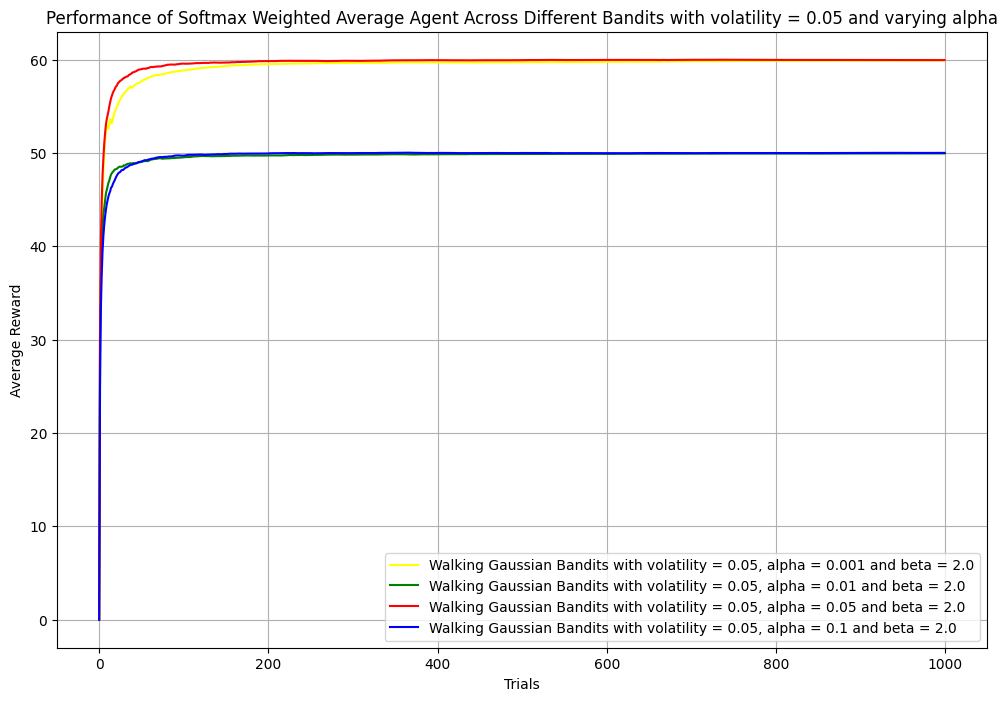

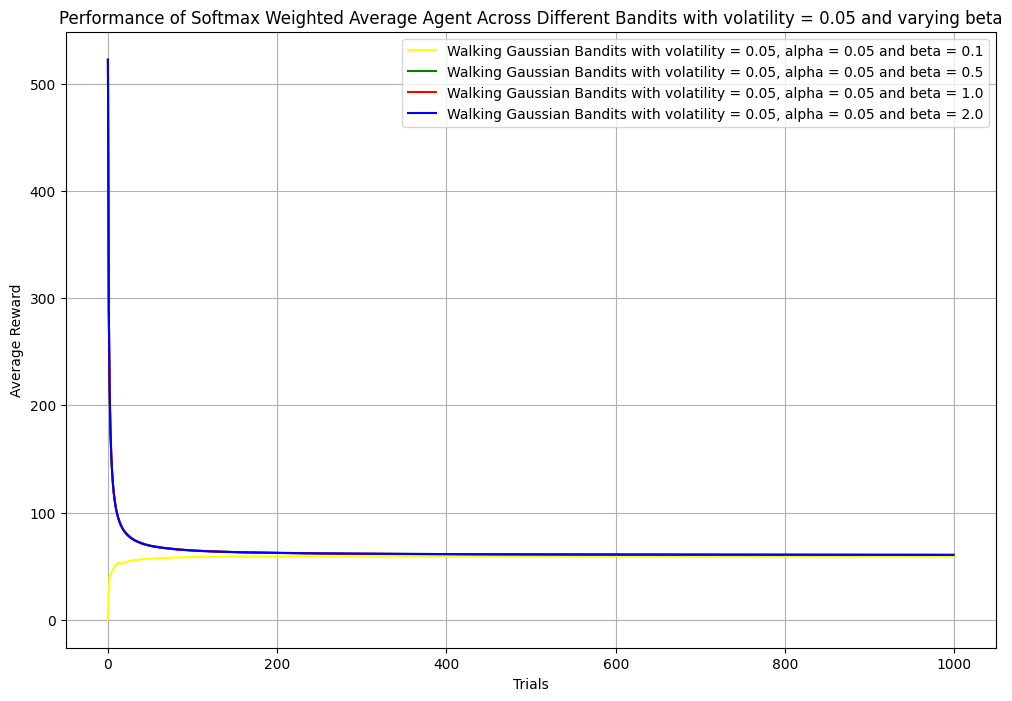

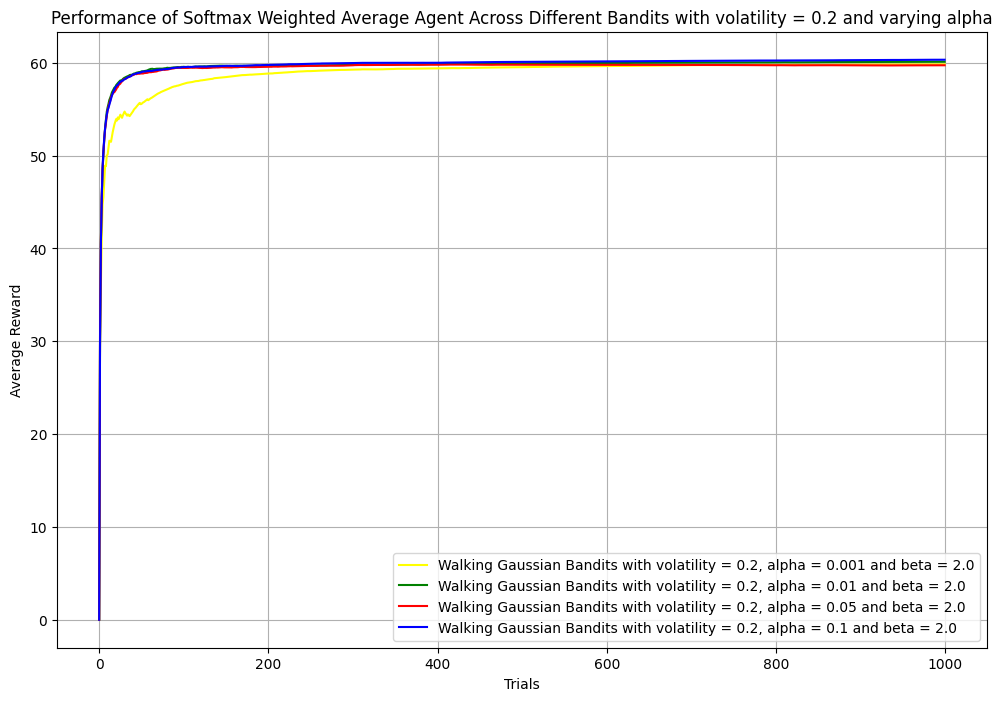

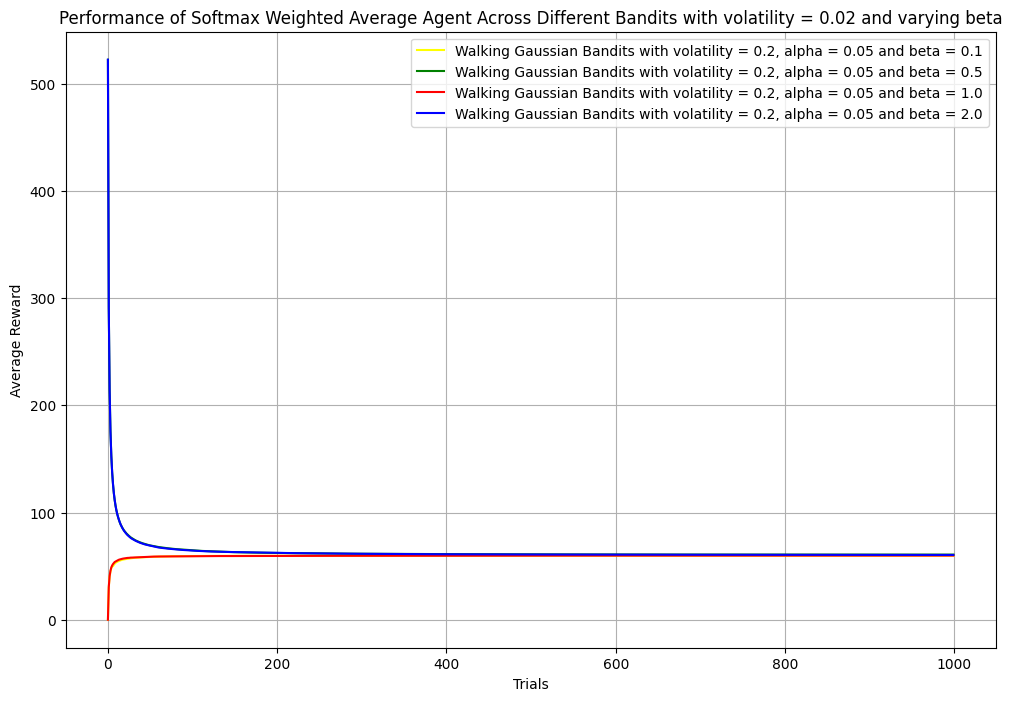

In [ ]:
# a function that contains all the steps to create a performance line with specific values, used from assignment 1
def all_steps(n_trials, n_bandits, alpha, beta, volatility, color):
  init_means_gaussian = [50, 60]
  reward_samples_walking_gaussian, _ = draw_from_k_walking_gaussian_bandits(n_trials, init_means_gaussian, volatility)
  agent_gaussian_walking = SoftmaxWeightedAverageAgent(n_bandits, alpha, beta)
  performance_gaussian_walking, _ = run_simulation(n_trials, reward_samples_walking_gaussian, agent_gaussian_walking)
  plt.plot(np.cumsum(performance_gaussian_walking) / (np.arange(n_trials) + 1), label=f"Walking Gaussian Bandits with volatility = {volatility}, alpha = {alpha} and beta = {beta}", color=color)

# volatility low
volatility = 0.05
#all steps with different values for alpha
plt.figure(figsize=(12, 8))
all_steps(n_trials=1000, n_bandits=2, alpha=0.001, beta=2.0, volatility=volatility, color='yellow')
all_steps(n_trials=1000, n_bandits=2, alpha=0.01, beta=2.0, volatility=volatility, color='green')
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=2.0, volatility=volatility, color='red')
all_steps(n_trials=1000, n_bandits=2, alpha=0.1, beta=2.0, volatility=volatility, color='blue')
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('Performance of Softmax Weighted Average Agent Across Different Bandits with volatility = 0.05 and varying alpha')
plt.legend()
plt.grid()
plt.show()

#all steps with different values for beta
plt.figure(figsize=(12, 8))
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=0.1, volatility=volatility, color='yellow')
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=0.5, volatility=volatility, color='green')
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=1.0, volatility=volatility, color='red')
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=2.0, volatility=volatility, color='blue')
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('Performance of Softmax Weighted Average Agent Across Different Bandits with volatility = 0.05 and varying beta')
plt.legend()
plt.grid()
plt.show()

# volatility low
volatility = 0.2
#all steps with different values for alpha
plt.figure(figsize=(12, 8))
all_steps(n_trials=1000, n_bandits=2, alpha=0.001, beta=2.0, volatility=volatility, color='yellow')
all_steps(n_trials=1000, n_bandits=2, alpha=0.01, beta=2.0, volatility=volatility, color='green')
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=2.0, volatility=volatility, color='red')
all_steps(n_trials=1000, n_bandits=2, alpha=0.1, beta=2.0, volatility=volatility, color='blue')
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('Performance of Softmax Weighted Average Agent Across Different Bandits with volatility = 0.2 and varying alpha')
plt.legend()
plt.grid()
plt.show()

#all steps with different values for beta
plt.figure(figsize=(12, 8))
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=0.1, volatility=volatility, color='yellow')
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=0.5, volatility=volatility, color='green')
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=1.0, volatility=volatility, color='red')
all_steps(n_trials=1000, n_bandits=2, alpha=0.05, beta=2.0, volatility=volatility, color='blue')
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('Performance of Softmax Weighted Average Agent Across Different Bandits with volatility = 0.02 and varying beta')
plt.legend()
plt.grid()
plt.show()



<div class="alert alert-success" role="alert">
<h2> Assignment 3: Alternatives to performance (30 points) </h2><br>

So far, we have encountered two measures of performance:
- Overall or average reward collected by the agent
- proportion of optimal (=greedy) choices
    
There is a another way to look at performance: How well do our expectations of the environment match with the true value of the environment? Put differently, how well do our Q-values track the reward probabilities that generate rewards? The idea is simple: The better our estimate about the true values, the better our decision making will be.
    
> Plot the Q values together with the reward probabilities and compare the performance of the same RL agents for binomial and Gaussian rewards in a walking/changing environment. (15 points)     

A simple metric that you could utilize to quantify performance is the correlation coefficient. High correlation means that Qvalues and true probabilities are aligned, with r=1 indicating a perfect match. Low correlation means that Qvalues and true probabilities are not aligned, with r=0 indicating no connection at all.

> Compare the performance of different agents. Can you manually fine-tune the agent's parameters to optimize correlation?  (15 points)


(Please note that averaging correlation coefficients, e.g. between blocks or agents, is a bit tricky. Use Fisher's z  transformation (<code>numpy.arctanh</code>), average, and then transform back (<code>numpy.tanh</code>), to obtain meaningful results. Alternatively you could also estimate one correlation coefficient for ALL data at once.)


</div>

[fisher's z](https://en.wikipedia.org/wiki/Fisher_transformation)<br>



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate binomial bandits with walking probabilities
def simulate_bandit_with_walking_probs(n_trials, init_probs, lr=0.05, volatility=0.05):
    n_bandits = len(init_probs)
    reward_samples = np.empty((n_trials, n_bandits))
    reward_probs = np.empty((n_trials, n_bandits))

    # Initialize the reward probabilities
    reward_probs[0, :] = init_probs
    for i in range(1, n_trials):
        reward_probs[i, :] = reward_probs[i-1, :] + np.random.normal(0, volatility, n_bandits)
        reward_probs[i, :] = np.clip(reward_probs[i, :], 0, 1)  # Clip to valid range

    # Draw samples from binomial distribution
    reward_samples = np.random.binomial(1, reward_probs)

    return reward_probs, reward_samples

# Parameters
n_trials = 1000
n_bandits = 2
learning_rate = 0.1  # Alpha
beta = 2.0   # Softmax inverse temperature
volatility_binomial = 0.01
volatility_gaussian = 10

#Binomial rewards with walking probabilities
init_probs_binomial = [0.5, 0.7]  # Initial probabilities for walking
reward_probs_binomial, reward_samples_binomial = simulate_bandit_with_walking_probs(n_trials, init_probs_binomial, lr=learning_rate, volatility=volatility_binomial)
agent_binomial = SoftmaxWeightedAverageAgent(n_bandits, alpha=learning_rate, beta=beta) #create an agent for binomial bandits
# action_values_binomial, true_probs_binomial = simulate_bandit_with_walking_probs(n_trials, reward_samples_binomial, agent_binomial) #run the simulation for binomial rewards

#Plot results for binomial bandits
plt.figure(figsize=(12, 6))
for i in range(n_bandits):
    plt.plot(true_probs_binomial[:, i], label=f"True Reward Probabilities ({init_probs_binomial[i]})")
    plt.plot(action_values_binomial[:, i], label=f"Q-values ({init_probs_binomial[i]})")
plt.title('Walking Binomial Bandits: Q-values vs. True Reward Probabilities')
plt.xlabel('Trial')
plt.ylabel('Values')
plt.legend(loc="upper right")
plt.grid()
plt.show()

# Gaussian rewards with walking mean rewards
init_means_gaussian = [60, 80]  # Initial mean for walking
reward_means_gaussian, reward_samples_gaussian, _ = draw_from_k_walking_gaussian_bandits(n_trials, init_means_gaussian, noise=volatility_gaussian, scale=10)
agent_gaussian = SoftmaxWeightedAverageAgent(n_bandits, alpha=learning_rate, beta=beta) #create an agent for Gaussian bandits
# action_values_gaussian, true_probs_gaussian = run_simulation_with_action_values(n_trials, reward_samples_gaussian, agent_gaussian) #run the simulation for Gaussian rewards

#Plot results for Gaussian bandits
plt.figure(figsize=(12, 6))
for i in range(n_bandits):
    plt.plot(true_probs_gaussian[:, i], label=f"True Reward Probabilities ({init_means_gaussian[i]})")
    plt.plot(action_values_gaussian[:, i], label=f"Q-values ({init_means_gaussian[i]})")
plt.title('Walking Gaussian Bandits: Q-values vs. True Mean Rewards')
plt.xlabel('Trial')
plt.ylabel('Values')
plt.legend(loc="upper right")
plt.grid()
plt.show()

# Function to calculate and return correlation coefficients
def calculate_correlation(action_values_history, true_probabilities_history):
    correlations = np.corrcoef(action_values_history.T, true_probabilities_history.T)[:len(action_values_history[0]), len(action_values_history[0]):]
    return correlations

# Function to print correlation coefficients
def print_correlation(correlations, bandit_labels):
    print("\nCorrelation coefficients between Q-values and True Probabilities:")
    for i in range(len(bandit_labels)):
        for j in range(len(bandit_labels)):
            print(f"Correlation between {bandit_labels[i]} and {bandit_labels[j]}: {correlations[i, j]:.4f}")

# Calculate and print correlations
correlations_binomial = calculate_correlation(action_values_binomial, true_probs_binomial)
correlations_gaussian = calculate_correlation(action_values_gaussian, true_probs_gaussian)

# Print correlation coefficients
bandit_labels_binomial = [f'Binomial Bandit {i+1}' for i in range(len(init_probs_binomial))]
bandit_labels_gaussian = [f'Gaussian Bandit {i+1}' for i in range(len(init_means_gaussian))]

print_correlation(correlations_binomial, bandit_labels_binomial)
print_correlation(correlations_gaussian, bandit_labels_gaussian)


NameError: name 'true_probs_binomial' is not defined

<Figure size 1200x600 with 0 Axes>

## additional material

For inspiration and more material on reinforcement learning and bandits, see

[link to model-free and model-based RL](https://github.com/ClaireSmid/Model-free_Model-based_Workshop)<br>


[link to recurrent neural networks and RL](https://github.com/kstach01/CogModelingRNNsTutorial)<br>

## Optional: The grid world problem

*Grid worlds* are simplified respresentations of the environment, that are often used for navigation simulation. As is implied by the name, grid worlds break down the environment into a grid, similar to a chess board. For the scope of this course we are going to stick with a very basic 4x4 gridworld.

Before we dive further into the code, a bit more background information on gridworlds.

Gridworlds are so-called [Markov Decision Processes](https://en.wikipedia.org/wiki/Markov_decision_process). In contrast to the previous bandit task, gridworlds usually are multi-step problems, meaning that actions executed in one state cannot only result in reward, but also affect the upcoming state. This necessitates the agent to not only consider the immediate reward but also the expected cumulative reward.

```
  ____    ____     ____   ____
  ____    ____     ____   ____

|| s00  |  s01  |  s02 | s03 ||
  ____    ____     ____   ____
    
|| s04  |  s05  |  s06 | s07 ||
  ____    ____     ____   ____
  
|| s08  |  s09  |  s10 | s11 ||
  ____    ____     ____   ____
   
|| s12  |  s13  |  s14 | s15 ||
  ____    ____     ____   ____
  ____    ____     ____   ____
```

Our agent always starts in the same start state (s_0, top left of board). From there, it will take *steps*, that gradually move him across the board. Movement is restricted to the cardinal directions (up, down, right, left). Reward is located in the terminal state (s_15, bottom right of board). Upon arrival at the site of reward, the agent receives the reward (associated with a positive value) and will be returned to the initial state, so the whole procedure can start again. The (time)steps between start and terminal state are regarded as a *run* (or *episode*). Start state, reward and terminal state do NOT change between runs. Thus, our gridworld environment is stable. Also, because each action transitions to a new state with 100% chance, the environment is also considered deterministic.

For this grid world example, we will implement the Q learning rule, which is defined as

$\LARGE Q_{new}(s,a) = Q_{old}(s,a) + \alpha * (R + \gamma max_{a} Q_{old}(s',a) - Q_{old}(s,a))$,

    where $\alpha$ is the learning rate,
    $\gamma$ is the discounting factor,
    and s' is the next state

Below, we define the most basic details for our gridworld.

In [ ]:
nTrial = 50 #specify how many times you want to run the q-learning function
nAgent = 10

method = 'egreedy' #options: greedy | egreedy | softmax

alpha = 0.1 #learning rate
beta = 1 #inverse temperature
gamma = 1 # discounting factor
epsilon = 0.1 #parameter for ε-greedy action selection

actions = np.array(['up', 'left', 'down', 'right'])

s_0 = 0 #start state
s_terminal = 15 #final state (goal)

envsize = 4 #size of the environment (n x n)
iZ = 0
states= np.empty([envsize,envsize],dtype=float)
for iY in range(envsize):
    for iX in range(envsize):
        states[iY][iX] = iZ
        iZ +=1
#print('states')
#print(states)

movecounter = np.empty([nTrial,nAgent] )

### Helper function

Some computational steps have to be performed multiple times.
Here we define those function so we can call them later on in the script.

In [ ]:
# this is not an essential package, but it helps us to save variables for visualisation
from copy import deepcopy

In [ ]:
def move1step(instate,action):

    coords = list(np.where(states == instate))

    if (action == 'up'):
        coords[0] -= 1
    if (action == 'down'):
        coords[0] += 1
    if (action == 'left'):
        coords[1] -= 1
    if (action == 'right'):
        coords[1] += 1

    if (coords[0] < 0):
        coords[0] = 0
    if (coords[1] < 0):
        coords[1] = 0
    if (coords[0] >= envsize):
        coords[0] = envsize-1
    if (coords[1] >= envsize):
        coords[1] = envsize-1

    outstate = states[coords[0],coords[1]]
    return(outstate)

def getReward(state1,state2):
    if (state2 == s_terminal):
        reward = 10 #final reward at the end of the run
    else:
        reward = 0 #intermediate reward (after each action)
    if (state1 == state2):
        reward = 0 #reward for running into a wall?
    return reward

Now that we have defined the most crucial parts for our grid world, we can put everything together.

For convenience, I have already added multiple agents, as this will allow us to draw more precise conclusions from the simulation data.

For the agent's parameters I have implemented very basic values. You can have a look how changing those parameters affects the performance in the grid world.

In [ ]:
print('Agent')
for iA in range(nAgent):

    print(iA, end=' ')
    Q = np.zeros([len(actions),envsize,envsize] )

    #print('initial Q matrix:\n' + str(Q) + '\n')
    Q0 = deepcopy(Q)

    for iT in range(nTrial): # loop for the different runs
        #if (iT % 100) == 0:
            #print(iT)
        state = s_0
        moves = 0
        while (state != s_terminal): # loop within one run

            coord0 = np.where(states == state)

            qvals = Q[:,coord0[0],coord0[1]]

            # select action using choice rules
            if (method == 'softmax'):
                pvals = np.exp(beta*qvals)/np.sum(np.exp(beta*qvals))
                action = np.random.choice(actions,size = 1, p = pvals.flatten())
            elif (method == 'greedy'):
                choices = np.array(qvals == np.max(qvals))
                action = np.random.choice(actions[choices.flatten()])
            elif (method == 'egreedy'):
                if (np.random.random() < epsilon):
                    action = np.random.choice(actions, size = 1)
                else:
                    choices = np.array(qvals == np.max(qvals))
                    action = np.random.choice(actions[choices.flatten()])
            else:
                action = np.random.choice(actions)

            # interact with environment
            next_state = move1step(state,action)
            #print('next state: '+str(next_state))
            reward = getReward(state,next_state)

            actionidx = (action==actions)
            coord1 = np.where(states == next_state)

            # update expectations using learing rules
            Q[actionidx,coord0[0],coord0[1]] = Q[actionidx,coord0[0],coord0[1]] + alpha * (reward + gamma * np.max(Q[:,coord1[0],coord1[1]]) - Q[actionidx,coord0[0],coord0[1]])

            if ((iT == 0) and (next_state == s_terminal)):
                #print('Q matrix before first successful run:\n' + str(Q) + '\n')
                Q1 = deepcopy(Q)

            # update variables
            state = next_state
            moves += 1

        #end of while loop
        movecounter[iT,iA] = moves
    #end of trial for loop
    #print('final Q matrix:\n' + str(Q) + '\n')
    Q2 = deepcopy(Q)
#end of agent for loop
#print('\n\nFinal Q(s,a) for agent '+str(iA))
#print(Q)

In order to better understand the agents' behavior in the gridworld we can again make use of the `print()` and `plot()` function.

<div class="alert alert-warning" role="alert">
<h2> Questions </h2><br>
Before we continue, think about the performance of our agent. Do you have any hypothesis about this? What would you expect from a RL agent? How should his behavior change?
    
</div>

In the following sections we will try to answer those questions.

### Plotting performance

**Question:** What is our hypothesis for the performance of our agent?

**Answer:** Performance for learning agents should improve over time. Therefore we should expect to find improvements in performance for our grid world agent. Performance can be measured in multiple different ways. For our grid world example, we could define performance as is already plotted below: the number of steps it takes the agents to get from start state to terminal state. While the agent is aimlessly roaming the gridworld in the beginning, it quickly picks up the optimal path to the goal.

In [ ]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.

xdata = range(nTrial)
ydata = np.mean(movecounter,axis=1)

ax.plot(xdata, ydata, label = method)  # Plot some data on the axes.

ax.set_title('Performance over time')
ax.set_xlabel('Run')
ax.set_ylabel('Number of moves')
ax.legend()

### Plotting values and policies

We can also visualize the state and action values of our gridworld.

In [ ]:
Qmat0 = np.max(Q0,axis=0)
Qmat1 = np.max(Q1,axis=0)
Qmat2 = np.max(Q2,axis=0)

print(Qmat0)
print(Qmat1)
print(Qmat2)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

layout = [['s0', 's5/6'], ['s1', 's4'], ['s2', 's3']]

min_val, max_val = -1, 10

for i in range(envsize):
    for j in range(envsize):
        ax1.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
        ax2.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
        ax3.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
ax1.matshow(Qmat0, cmap=plt.cm.Blues)
ax2.matshow(Qmat1, cmap=plt.cm.Blues)
ax3.matshow(Qmat2, cmap=plt.cm.Blues)

ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax3.axes.xaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)

ax1.title.set_text('Run 0')
ax1.title.set_size(20)
ax2.title.set_text('Run 1')
ax2.title.set_size(20)
ax3.title.set_text('Run X')
ax3.title.set_size(20)


<div class="alert alert-success" role="alert">
<h2> Ideas for individual assignments </h2><br>
The current grid world is perfectly deterministic. Actions reliably lead to the same outcome. Reward is always hidden in the same location. Recall that for our bandit example reward delivery was probabilistic. Can you implement some randomness in the grid world as well? Think about a few possible options. How could you implement those and what would be the consequences for agents' learning and decision-making?<br>
    
>Discuss your ideas with the workgroup teacher!
    
</div>

<div class="alert alert-success" role="alert">
<h2> Ideas for individual assignments </h2><br>
So far, we have only implemented different decision rules at this point. But we could also think about different learning rules. As discussed in the lecture, a prominent example from Sutton & Barto (2018, p.132) is the cliff world. In their variant of the grid world, learning for the different learning rules translates into very distinct behavioral patterns. It nicely illustrates how small changes in the algorithm can have quite strong effects on decision making. Have a look at the example. Can you construct a cliff world and replicate the findings reported by Sutton & Barto? <br>
    
>Discuss your ideas with the workgroup teacher!
</div>